In [40]:
import json
import matplotlib.pyplot as plt

In [41]:
import json

# JSON 파일 경로
file_path = 'lane_change_midpoints.json'

# 파일 열기와 데이터 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    lane_change_midpoints_3vehicle = json.load(file)

# JSON 파일 경로
file_path = 'depth_dic.json'

# 파일 열기와 데이터 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    depth_dic = json.load(file)

In [42]:
for vehicle, lanes in lane_change_midpoints_3vehicle.items():
    print(vehicle, lanes)
    for lane in lanes:    
        if lane['end_lane']==-1:
            lane['end_lane']=lane['start_lane']

vehicle0 [{'start_lane': 2, 'end_lane': 3, 'enter_time': 0, 'leave_time': 0.13333333333333333, 'midpoint_time': 0.06666666666666667}, {'start_lane': 3, 'end_lane': 2, 'enter_time': 2.0, 'leave_time': 3.93, 'midpoint_time': 2.93}, {'start_lane': 2, 'end_lane': 1, 'enter_time': 3.93, 'leave_time': 4.8, 'midpoint_time': 4.33}, {'start_lane': 1, 'end_lane': 2, 'enter_time': 4.8, 'leave_time': 6.27, 'midpoint_time': 5.53}, {'start_lane': 2, 'end_lane': 3, 'enter_time': 6.27, 'leave_time': 6.93, 'midpoint_time': 6.6}]
vehicle1 [{'start_lane': 1, 'end_lane': -1, 'enter_time': 0, 'leave_time': 10, 'midpoint_time': 5}]
vehicle8 [{'start_lane': 1, 'end_lane': -1, 'enter_time': 0, 'leave_time': 10, 'midpoint_time': 5}]


In [43]:
# 1초당 15프레임
frames_per_second = 15

# 각 구간에 대해 프레임별로 lane 위치 계산

vehicle_lane={}

for vehicle, movement_data in lane_change_midpoints_3vehicle.items():
    lane_positions = []
    for i, data in enumerate(movement_data):
        start_lane = data['start_lane']
        end_lane = data['end_lane']
        enter_time = data['enter_time']
        leave_time = data['leave_time']
        
        # 구간에 대한 프레임 수
        num_frames = int((leave_time - enter_time) * frames_per_second)
        
        # 선형적으로 lane 이동
        for frame in range(num_frames):
            # 현재 프레임에서의 시간 비율
            time_ratio = frame / num_frames
            # 현재 프레임에서의 lane 위치 계산
            current_lane = start_lane + (end_lane - start_lane) * time_ratio
            lane_positions.append(current_lane)
        
        # leave_time 이후에 그 다음 구간의 enter_time까지 이전 차선 유지
        if i < len(movement_data) - 1:  # 마지막 구간이 아니면
            next_enter_time = movement_data[i + 1]['enter_time']
            # leave_time과 next_enter_time 사이의 시간
            hold_time = next_enter_time - leave_time
            if hold_time > 0:
                # 해당 시간 동안 이전 차선(end_lane)을 유지
                hold_frames = int(hold_time * frames_per_second)
                for frame in range(hold_frames):
                    lane_positions.append(end_lane)
        
    vehicle_lane[vehicle]=lane_positions

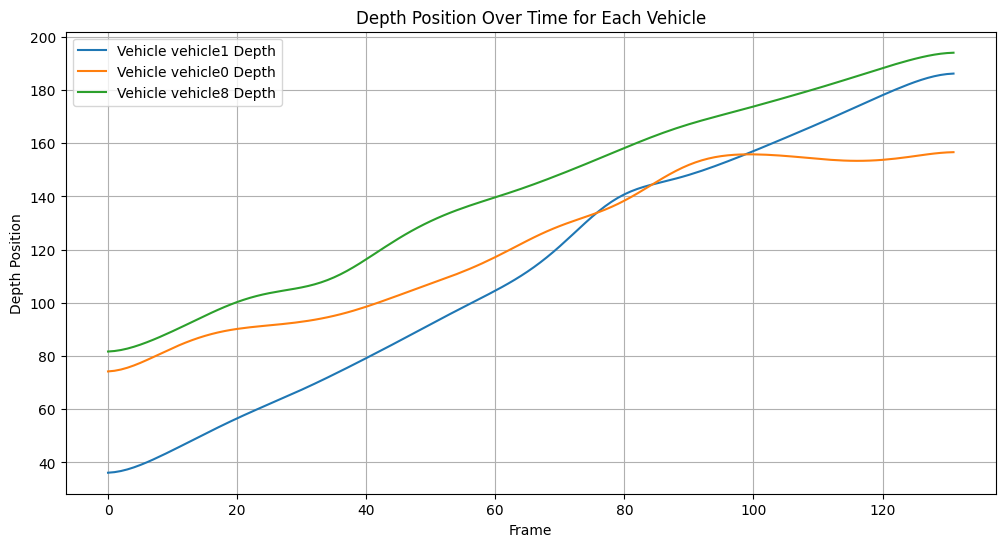

In [44]:
# 각 차량의 depth 변화 그래프
plt.figure(figsize=(12, 6))

for key, value in depth_dic.items():
    plt.plot(value, label=f'Vehicle {key} Depth')
plt.xlabel('Frame')
plt.ylabel('Depth Position')
plt.title('Depth Position Over Time for Each Vehicle')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
def sub_check_collision(lane_pos_1, lane_pos_2, depth_pos_1, depth_pos_2, lane_threshold=0.1, depth_threshold=10):
    # 차선 차이 계산
    lane_diff = abs(lane_pos_1 - lane_pos_2)
    # 깊이 차이 계산
    depth_diff = abs(depth_pos_1 - depth_pos_2)
    
    # 사고 발생 조건: 차선 차이가 임계값 이하이고, 깊이 차이가 임계값 이하인 경우
    if lane_diff<=lane_threshold and depth_diff<= depth_threshold:
        return True
    else:
        return False

def check_collision(vehicle_lane, depth_dic):
    collision_results = []
    keys = list(vehicle_lane.keys())
    
    # 모든 프레임에 대해 충돌 여부 확인 
    num_frames = len(vehicle_lane[keys[0]])  
    
    for frame in range(num_frames):  # 각 프레임을 반복
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                # 각 차량의 현재 프레임에서의 차선 위치와 깊이 위치 가져오기
                lane_1, lane_2 = vehicle_lane[keys[i]][frame], vehicle_lane[keys[j]][frame]
                depth_1, depth_2 = depth_dic[keys[i]][frame], depth_dic[keys[j]][frame]
    
                # 충돌 여부 확인
                collision = sub_check_collision(lane_1, lane_2, depth_1, depth_2)
                if collision==True:
                    collision_results.append((frame, keys[i], keys[j]))  # (프레임, 앞 차량1 ID, 뒤 차량2 ID, 충돌 여부)
    
    return collision_results
    
ori_collision_results=check_collision(vehicle_lane, depth_dic)


# 결과 출력
for result in ori_collision_results:
    frame, vehicle1, vehicle2 = result
    print(f"프레임 {frame}: 차량 {vehicle1}와 차량 {vehicle2} 간 충돌")

프레임 70: 차량 vehicle0와 차량 vehicle1 간 충돌
프레임 71: 차량 vehicle0와 차량 vehicle1 간 충돌
프레임 72: 차량 vehicle0와 차량 vehicle1 간 충돌
프레임 73: 차량 vehicle0와 차량 vehicle1 간 충돌


In [46]:
print(depth_dic['vehicle0'][74])
print(depth_dic['vehicle1'][74])

132.33956909179688
130.1909798650243


In [47]:
def classify_collision(lane_pos_1, lane_pos_2, depth_pos_1, depth_pos_2, threshold=3):
    # 차선 차이 계산
    lane_diff = abs(lane_pos_1 - lane_pos_2)
    # 깊이 차이 계산
    depth_diff = abs(depth_pos_1 - depth_pos_2)

    
    if depth_diff <= threshold: 
        return 'Side Collision'
    elif depth_pos_1<depth_pos_2:
        return 'Head-on Collision'
    # 후방 충돌: 차선은 같고, 한 차량의 깊이가 다른 차량보다 뒤에 있을 때
    else:
        return 'Rear-end Collision'

# 충돌 발생한 프레임에 대해 각 차량의 위치를 확인하고, 충돌 유형을 판별
collision_results_with_type = []
for frame, vehicle_1, vehicle_2 in ori_collision_results:
    lane_1 = vehicle_lane[vehicle_1][frame]
    lane_2 = vehicle_lane[vehicle_2][frame]
    depth_1 = depth_dic[vehicle_1][frame]
    depth_2 = depth_dic[vehicle_2][frame]
    
    collision_type = classify_collision(lane_1, lane_2, depth_1, depth_2)
    collision_results_with_type.append((frame, vehicle_1, vehicle_2, collision_type))  # (프레임, 차량1, 차량2, 충돌 유형)

# 충돌 결과 출력
for result in collision_results_with_type:
    print(f"프레임 {result[0]}에서 차량 {result[1]}와 차량 {result[2]}의 충돌 유형: {result[3]}")

프레임 70에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 71에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 72에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 73에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision


In [48]:
import numpy as np

def smooth_depth_transition_single_vehicle(origin_depth, changed_depth, change, frame, window_size=7, end_frame=None):
    # 사고 프레임의 깊이를 바로 설정
    changed_depth[frame] = change

    # 스무딩 시작 프레임 계산
    start_frame = max(0, frame - window_size)
    
    # 스무딩 종료 프레임 계산 (end_frame이 None일 경우 배열의 끝까지)
    if end_frame is None:
        end_frame = len(changed_depth)
    else:
        end_frame = min(len(changed_depth), end_frame)

    # start_frame부터 frame까지의 구간을 스무딩
    if start_frame < frame:
        # 사고 이전 프레임에서 점진적으로 깊이를 변경 (frame-1까지)
        changed_depth[start_frame:frame] = np.linspace(origin_depth[start_frame], changed_depth[frame], frame - start_frame)

    # frame부터 end_frame까지의 구간을 점진적으로 스무딩
    if frame + 1 < end_frame:
        changed_depth[frame:end_frame] = np.linspace(changed_depth[frame], origin_depth[end_frame - 1], end_frame - frame)

    return changed_depth


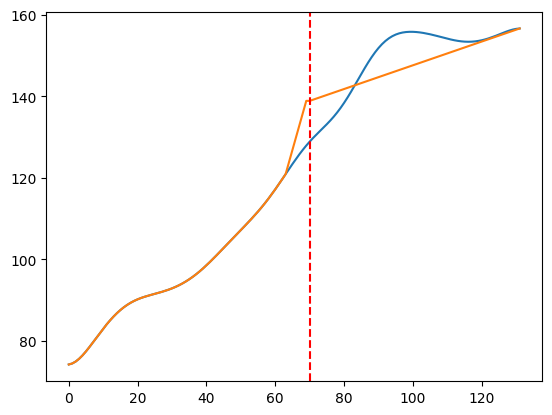

In [49]:
## rear collision

frame, vehicle1, vehicle2=ori_collision_results[0] 
origin_depth=depth_dic[vehicle1]
changed_depth=origin_depth.copy()

changed_depth=smooth_depth_transition_single_vehicle(origin_depth, changed_depth, origin_depth[frame]+10, frame)

plt.plot(origin_depth, label="ori")
plt.plot(changed_depth, label="cha")
plt.axvline(x=frame, color='red', linestyle='--', label='x = 75')
plt.show()

In [50]:
changed_depth_dic=depth_dic.copy()
changed_depth_dic[vehicle1]=changed_depth
collision_results=check_collision(vehicle_lane, changed_depth_dic)
collision_results_with_type = []
for frame, vehicle_1, vehicle_2 in collision_results:
    lane_1 = vehicle_lane[vehicle_1][frame]
    lane_2 = vehicle_lane[vehicle_2][frame]
    depth_1 = depth_dic[vehicle_1][frame]
    depth_2 = depth_dic[vehicle_2][frame]
    
    collision_type = classify_collision(lane_1, lane_2, depth_1, depth_2)
    collision_results_with_type.append((frame, vehicle_1, vehicle_2, collision_type))  # (프레임, 차량1, 차량2, 충돌 유형)

# 충돌 결과 출력
for result in collision_results_with_type:
    print(f"프레임 {result[0]}에서 차량 {result[1]}와 차량 {result[2]}의 충돌 유형: {result[3]}")

프레임 70에서 차량 vehicle0와 차량 vehicle8의 충돌 유형: Head-on Collision


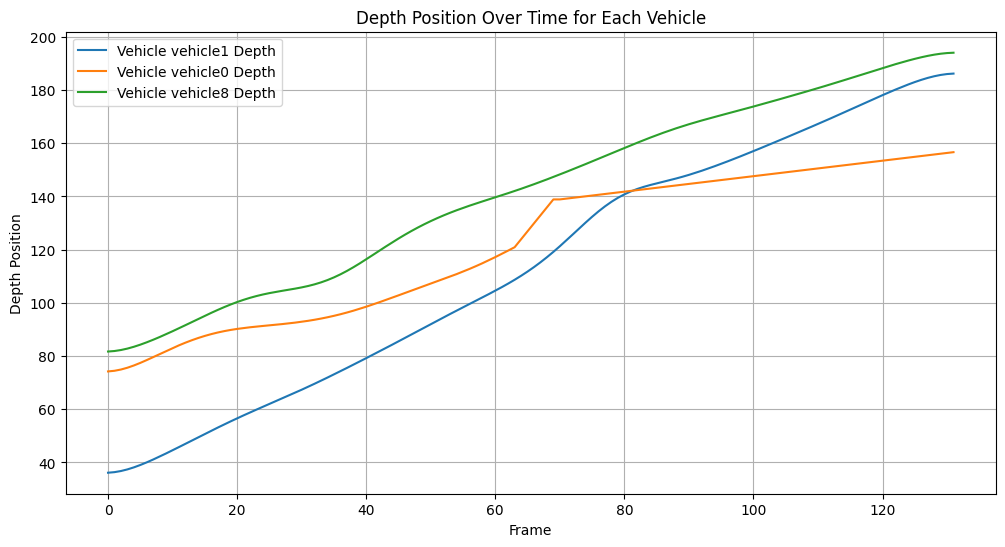

In [51]:
# 각 차량의 depth 변화 그래프
plt.figure(figsize=(12, 6))

for key, value in changed_depth_dic.items():
    plt.plot(value, label=f'Vehicle {key} Depth')
plt.xlabel('Frame')
plt.ylabel('Depth Position')
plt.title('Depth Position Over Time for Each Vehicle')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import json

# changed_depth_dic 저장 (JSON 형식)
with open("changed_depth_dic1.json", "w") as f:
    json.dump(changed_depth_dic, f)

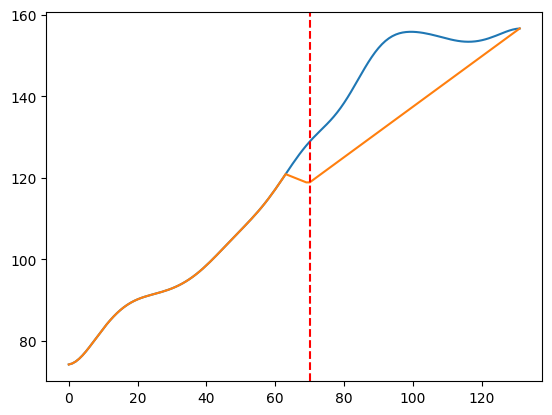

In [53]:
## 'Head-on Collision'
frame, vehicle1, vehicle2=ori_collision_results[0]  ## vehicle 1이 앞, vehicle 2가 뒤
origin_depth=depth_dic[vehicle1]
changed_depth=origin_depth.copy()

changed_depth=smooth_depth_transition_single_vehicle(origin_depth, changed_depth, origin_depth[frame]-10, frame)

plt.plot(origin_depth, label="ori")
plt.plot(changed_depth, label="cha")
plt.axvline(x=frame, color='red', linestyle='--', label='x = 75')
plt.show()

In [54]:
changed_depth_dic=depth_dic.copy()
changed_depth_dic[vehicle1]=changed_depth
collision_results=check_collision(vehicle_lane, changed_depth_dic)
collision_results_with_type = []
for frame, vehicle_1, vehicle_2 in collision_results:
    lane_1 = vehicle_lane[vehicle_1][frame]
    lane_2 = vehicle_lane[vehicle_2][frame]
    depth_1 = depth_dic[vehicle_1][frame]
    depth_2 = depth_dic[vehicle_2][frame]
    
    collision_type = classify_collision(lane_1, lane_2, depth_1, depth_2)
    collision_results_with_type.append((frame, vehicle_1, vehicle_2, collision_type))  # (프레임, 차량1, 차량2, 충돌 유형)

# 충돌 결과 출력
for result in collision_results_with_type:
    print(f"프레임 {result[0]}에서 차량 {result[1]}와 차량 {result[2]}의 충돌 유형: {result[3]}")

프레임 70에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 71에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 72에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 73에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision


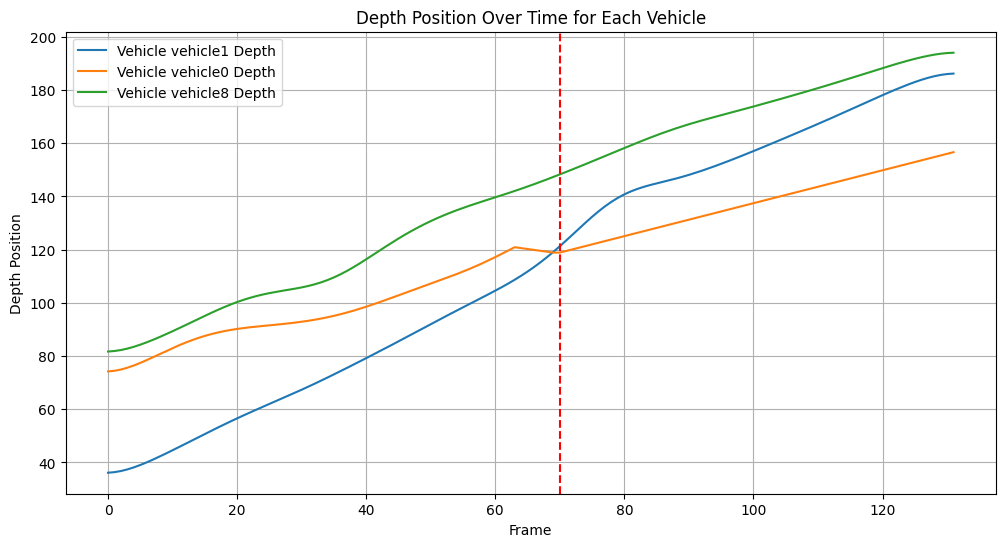

In [55]:
# 각 차량의 depth 변화 그래프
plt.figure(figsize=(12, 6))

for key, value in changed_depth_dic.items():
    plt.plot(value, label=f'Vehicle {key} Depth')
plt.xlabel('Frame')
plt.ylabel('Depth Position')
plt.title('Depth Position Over Time for Each Vehicle')
plt.legend()
plt.grid(True)
plt.axvline(x=collision_results_with_type[0][0], color='red', linestyle='--', label='x = 75')
plt.show()

In [56]:
import json

# changed_depth_dic 저장 (JSON 형식)
with open("changed_depth_dic2.json", "w") as f:
    json.dump(changed_depth_dic, f)


In [57]:
## -- 정세훈 파이썬 

In [58]:
def depth_to_speed(depth, fps=15):
    time_interval = 1 / fps
    depth_diff = np.diff(depth)
    speed = depth_diff / time_interval
    
    return speed

speed_dic = {}

for key, depth_values in depth_dic.items():
    speed_dic[key] = depth_to_speed(depth_values, fps=15)
    # plt.plot(speed, label=key)  # 각 객체의 속도를 같은 그래프에 표시
    # plt.title(f"{key} Speed over Frames by Object")
    # plt.xlabel("Frame")
    # plt.ylabel("Speed")
    # plt.show()

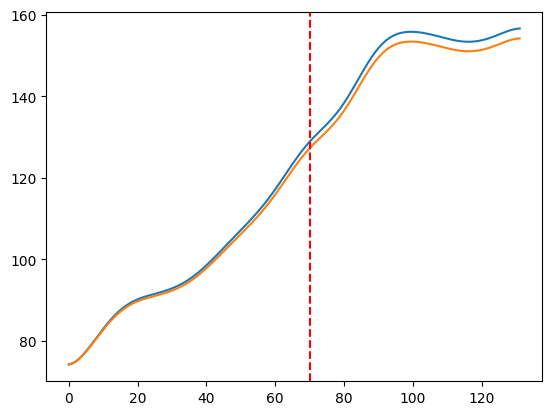

In [59]:
## rear collision

threshold=6
frame, vehicle1, vehicle2=ori_collision_results[0]
ratio=1+(depth_dic[vehicle2][frame]+threshold-depth_dic[vehicle1][frame])/(depth_dic[vehicle1][frame]-depth_dic[vehicle1][0])

origin_depth=depth_dic[vehicle1]
changed_depth=np.array(origin_depth.copy())

init=changed_depth[0]
changed_depth-=init
changed_depth*=ratio
changed_depth+=init

plt.plot(origin_depth, label="ori")
plt.plot(changed_depth, label="cha")
plt.axvline(x=frame, color='red', linestyle='--', label='x = 75')
plt.show()

In [60]:
changed_depth_dic=depth_dic.copy()
changed_depth_dic[vehicle1]=list(changed_depth)
collision_results=check_collision(vehicle_lane, changed_depth_dic)
collision_results_with_type = []
for frame, vehicle_1, vehicle_2 in collision_results:
    lane_1 = vehicle_lane[vehicle_1][frame]
    lane_2 = vehicle_lane[vehicle_2][frame]
    depth_1 = depth_dic[vehicle_1][frame]
    depth_2 = depth_dic[vehicle_2][frame]
    
    collision_type = classify_collision(lane_1, lane_2, depth_1, depth_2)
    collision_results_with_type.append((frame, vehicle_1, vehicle_2, collision_type))  # (프레임, 차량1, 차량2, 충돌 유형)

# 충돌 결과 출력
for result in collision_results_with_type:
    print(f"프레임 {result[0]}에서 차량 {result[1]}와 차량 {result[2]}의 충돌 유형: {result[3]}")

프레임 70에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 71에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 72에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 73에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision


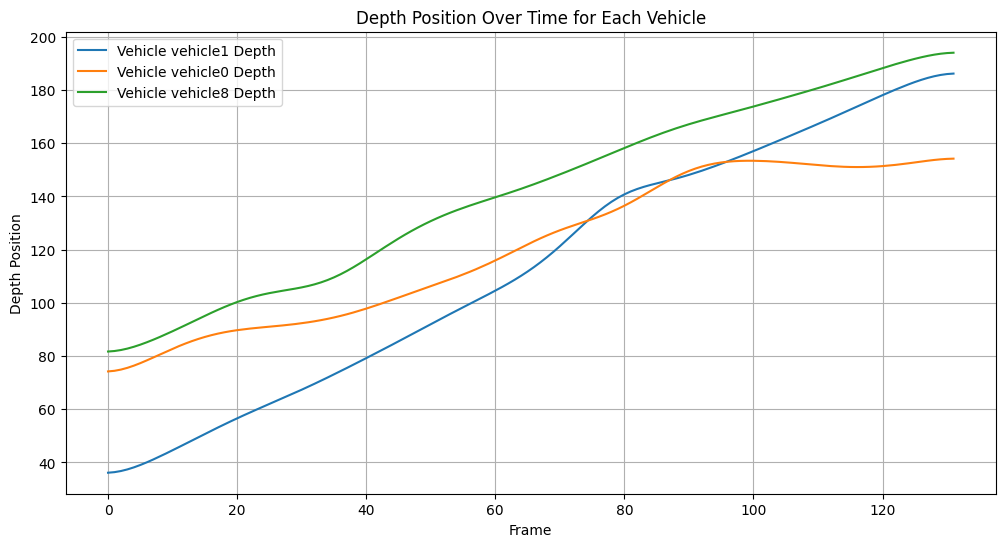

In [61]:
# 각 차량의 depth 변화 그래프
plt.figure(figsize=(12, 6))

for key, value in changed_depth_dic.items():
    plt.plot(value, label=f'Vehicle {key} Depth')
plt.xlabel('Frame')
plt.ylabel('Depth Position')
plt.title('Depth Position Over Time for Each Vehicle')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
import json

# changed_depth_dic 저장 (JSON 형식)
with open("changed_depth_dic1.json", "w") as f:
    json.dump(changed_depth_dic, f)

In [64]:
def depth_to_velocity(depthlist, time_interval=1):

    velocity_list = []
    
    for i in range(1, len(depthlist)):
        depth_difference = depthlist[i] - depthlist[i - 1]
        velocity = depth_difference / time_interval
        velocity_list.append(velocity)
    
    return velocity_list

# 예시 사용법




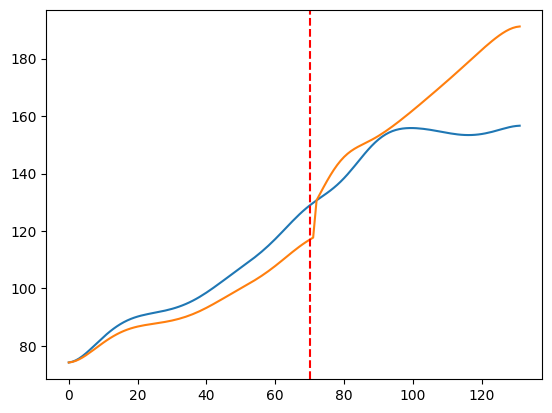

In [76]:
threshold=4.3
frame, vehicle1, vehicle2=ori_collision_results[0]
ratio=1+(depth_dic[vehicle2][frame]-threshold-depth_dic[vehicle1][frame])/(depth_dic[vehicle1][frame]-depth_dic[vehicle1][0])

origin_depth=depth_dic[vehicle1]
changed_depth=np.array(origin_depth.copy())

init=changed_depth[0]
changed_depth-=init
changed_depth*=ratio
changed_depth+=init

temp=list(np.array(depth_dic[vehicle2][frame+2:])+5)

changed_depth[frame+2:]=temp

plt.plot(origin_depth, label="ori")
plt.plot(changed_depth, label="cha")
plt.axvline(x=frame, color='red', linestyle='--', label='x = 75')
plt.show()

In [77]:
changed_depth_dic=depth_dic.copy()
changed_depth_dic[vehicle1]=list(changed_depth)
collision_results=check_collision(vehicle_lane, changed_depth_dic)
collision_results_with_type = []
for frame, vehicle_1, vehicle_2 in collision_results:
    lane_1 = vehicle_lane[vehicle_1][frame]
    lane_2 = vehicle_lane[vehicle_2][frame]
    depth_1 = depth_dic[vehicle_1][frame]
    depth_2 = depth_dic[vehicle_2][frame]
    
    collision_type = classify_collision(lane_1, lane_2, depth_1, depth_2)
    collision_results_with_type.append((frame, vehicle_1, vehicle_2, collision_type))  # (프레임, 차량1, 차량2, 충돌 유형)

# 충돌 결과 출력
for result in collision_results_with_type:
    print(f"프레임 {result[0]}에서 차량 {result[1]}와 차량 {result[2]}의 충돌 유형: {result[3]}")

프레임 70에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 71에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 72에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision
프레임 73에서 차량 vehicle0와 차량 vehicle1의 충돌 유형: Rear-end Collision


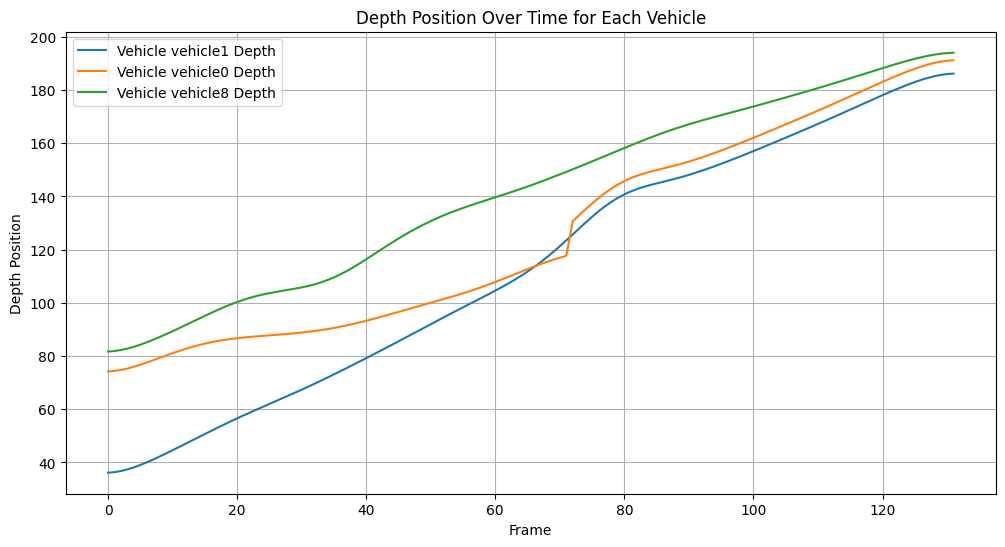

In [78]:
# 각 차량의 depth 변화 그래프
plt.figure(figsize=(12, 6))

for key, value in changed_depth_dic.items():
    plt.plot(value, label=f'Vehicle {key} Depth')
plt.xlabel('Frame')
plt.ylabel('Depth Position')
plt.title('Depth Position Over Time for Each Vehicle')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
import json

# changed_depth_dic 저장 (JSON 형식)
with open("changed_depth_dic2.json", "w") as f:
    json.dump(changed_depth_dic, f)

In [80]:
changed_depth_dic

{'vehicle1': [36.11730026253573,
  36.33465618064026,
  36.75788737162141,
  37.36600146986935,
  38.1318636320024,
  39.02605358474599,
  40.020291626255755,
  41.089801890393296,
  42.214403112779266,
  43.37849435182585,
  44.570319903414656,
  45.78093425308093,
  47.00319797242637,
  48.23099740414335,
  49.458756594379395,
  50.681227422979426,
  51.89350299480522,
  53.09117429542262,
  54.27060562935525,
  55.42922088832633,
  56.56572859993377,
  57.68029235088097,
  58.77458243047273,
  59.851692025029685,
  60.91591906819068,
  61.97243306315101,
  63.026861685026006,
  64.08484230841385,
  65.15158745451049,
  66.23151037959875,
  67.32794850684878,
  68.44300968650619,
  69.57755120790698,
  70.73128594258108,
  71.90299566602978,
  73.0908199394583,
  74.29258110861227,
  75.50610285660618,
  76.72948178036314,
  77.96127856149387,
  79.20060675594364,
  80.44711166503063,
  81.70084727945195,
  82.9620737707351,
  84.23100939078132,
  85.50757735355788,
  86.791189462351